# Transfer Learning In PyTorch
The goal of this assignment is to implement pretrained models in Pytorch to perform classification and test it out on mnist data. All the code will be implemented in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
%cd gdrive/MyDrive/Colab\ Notebooks/HW3

First, let’s install modules not already installed by Google Colab.

In [3]:
! pip install torch_utils

In the begining, please import all the package you need. We provide some packages here, which might be helpful when you build your code.

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from __future__ import print_function, division

import torch
import torch.nn as nn
from torch import optim, cuda, Tensor
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from timeit import default_timer as timer
import copy
import pandas as pd


# Task: Use MobileNet V3 for the MNIST data
Here, we will use the MobileNet v3 model for the MNIST data.

In [5]:
traindir = f"data/MNIST/train"
validdir = f"data/MNIST/val"

save_file_name = f'mobilenetv3-transfer.pt'
checkpoint_path = f'mobilenetv3-transfer.pth'

# Change to fit hardware
num_workers = 0
batch_size = 64
num_workers, batch_size

(0, 64)

In [6]:
# define transforms
# Image transformations
image_transforms = {
    'train':
        transforms.Compose([

            transforms.ToTensor(),
            transforms.Normalize((0.1307,),(0.3081,))
        ]),
    'valid':
        transforms.Compose([

            transforms.ToTensor(),
            transforms.Normalize((0.1307,),(0.3081,))
        ])
}

Now for each original image, we can obtain several processed images. Now we can load the grocery data here. Since we load all the images from folders, and we need to extract the labels from folder names, the dataloader might be different. Then, we can check all the classes in our new dataset.

In [7]:
# Datasets from folders

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid'])

}

# Dataloader iterators, make sure to shuffle
# You can use the same dataloader in HW3

dataloaders = {
    'train': torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=num_workers),
    'val': torch.utils.data.DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=num_workers)
}


# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
validationiter = iter(dataloaders['val'])

categories = []
for d in os.listdir(traindir):
    categories.append(d)

n_classes = len(categories)
n_classes
#print(f'There are {n_classes} different classes.')

10

Let's take a look at the data augmentation we've defined. After the data augmentation, the image values might be out of the range. Therefore, when we print the images, we may clip the value.

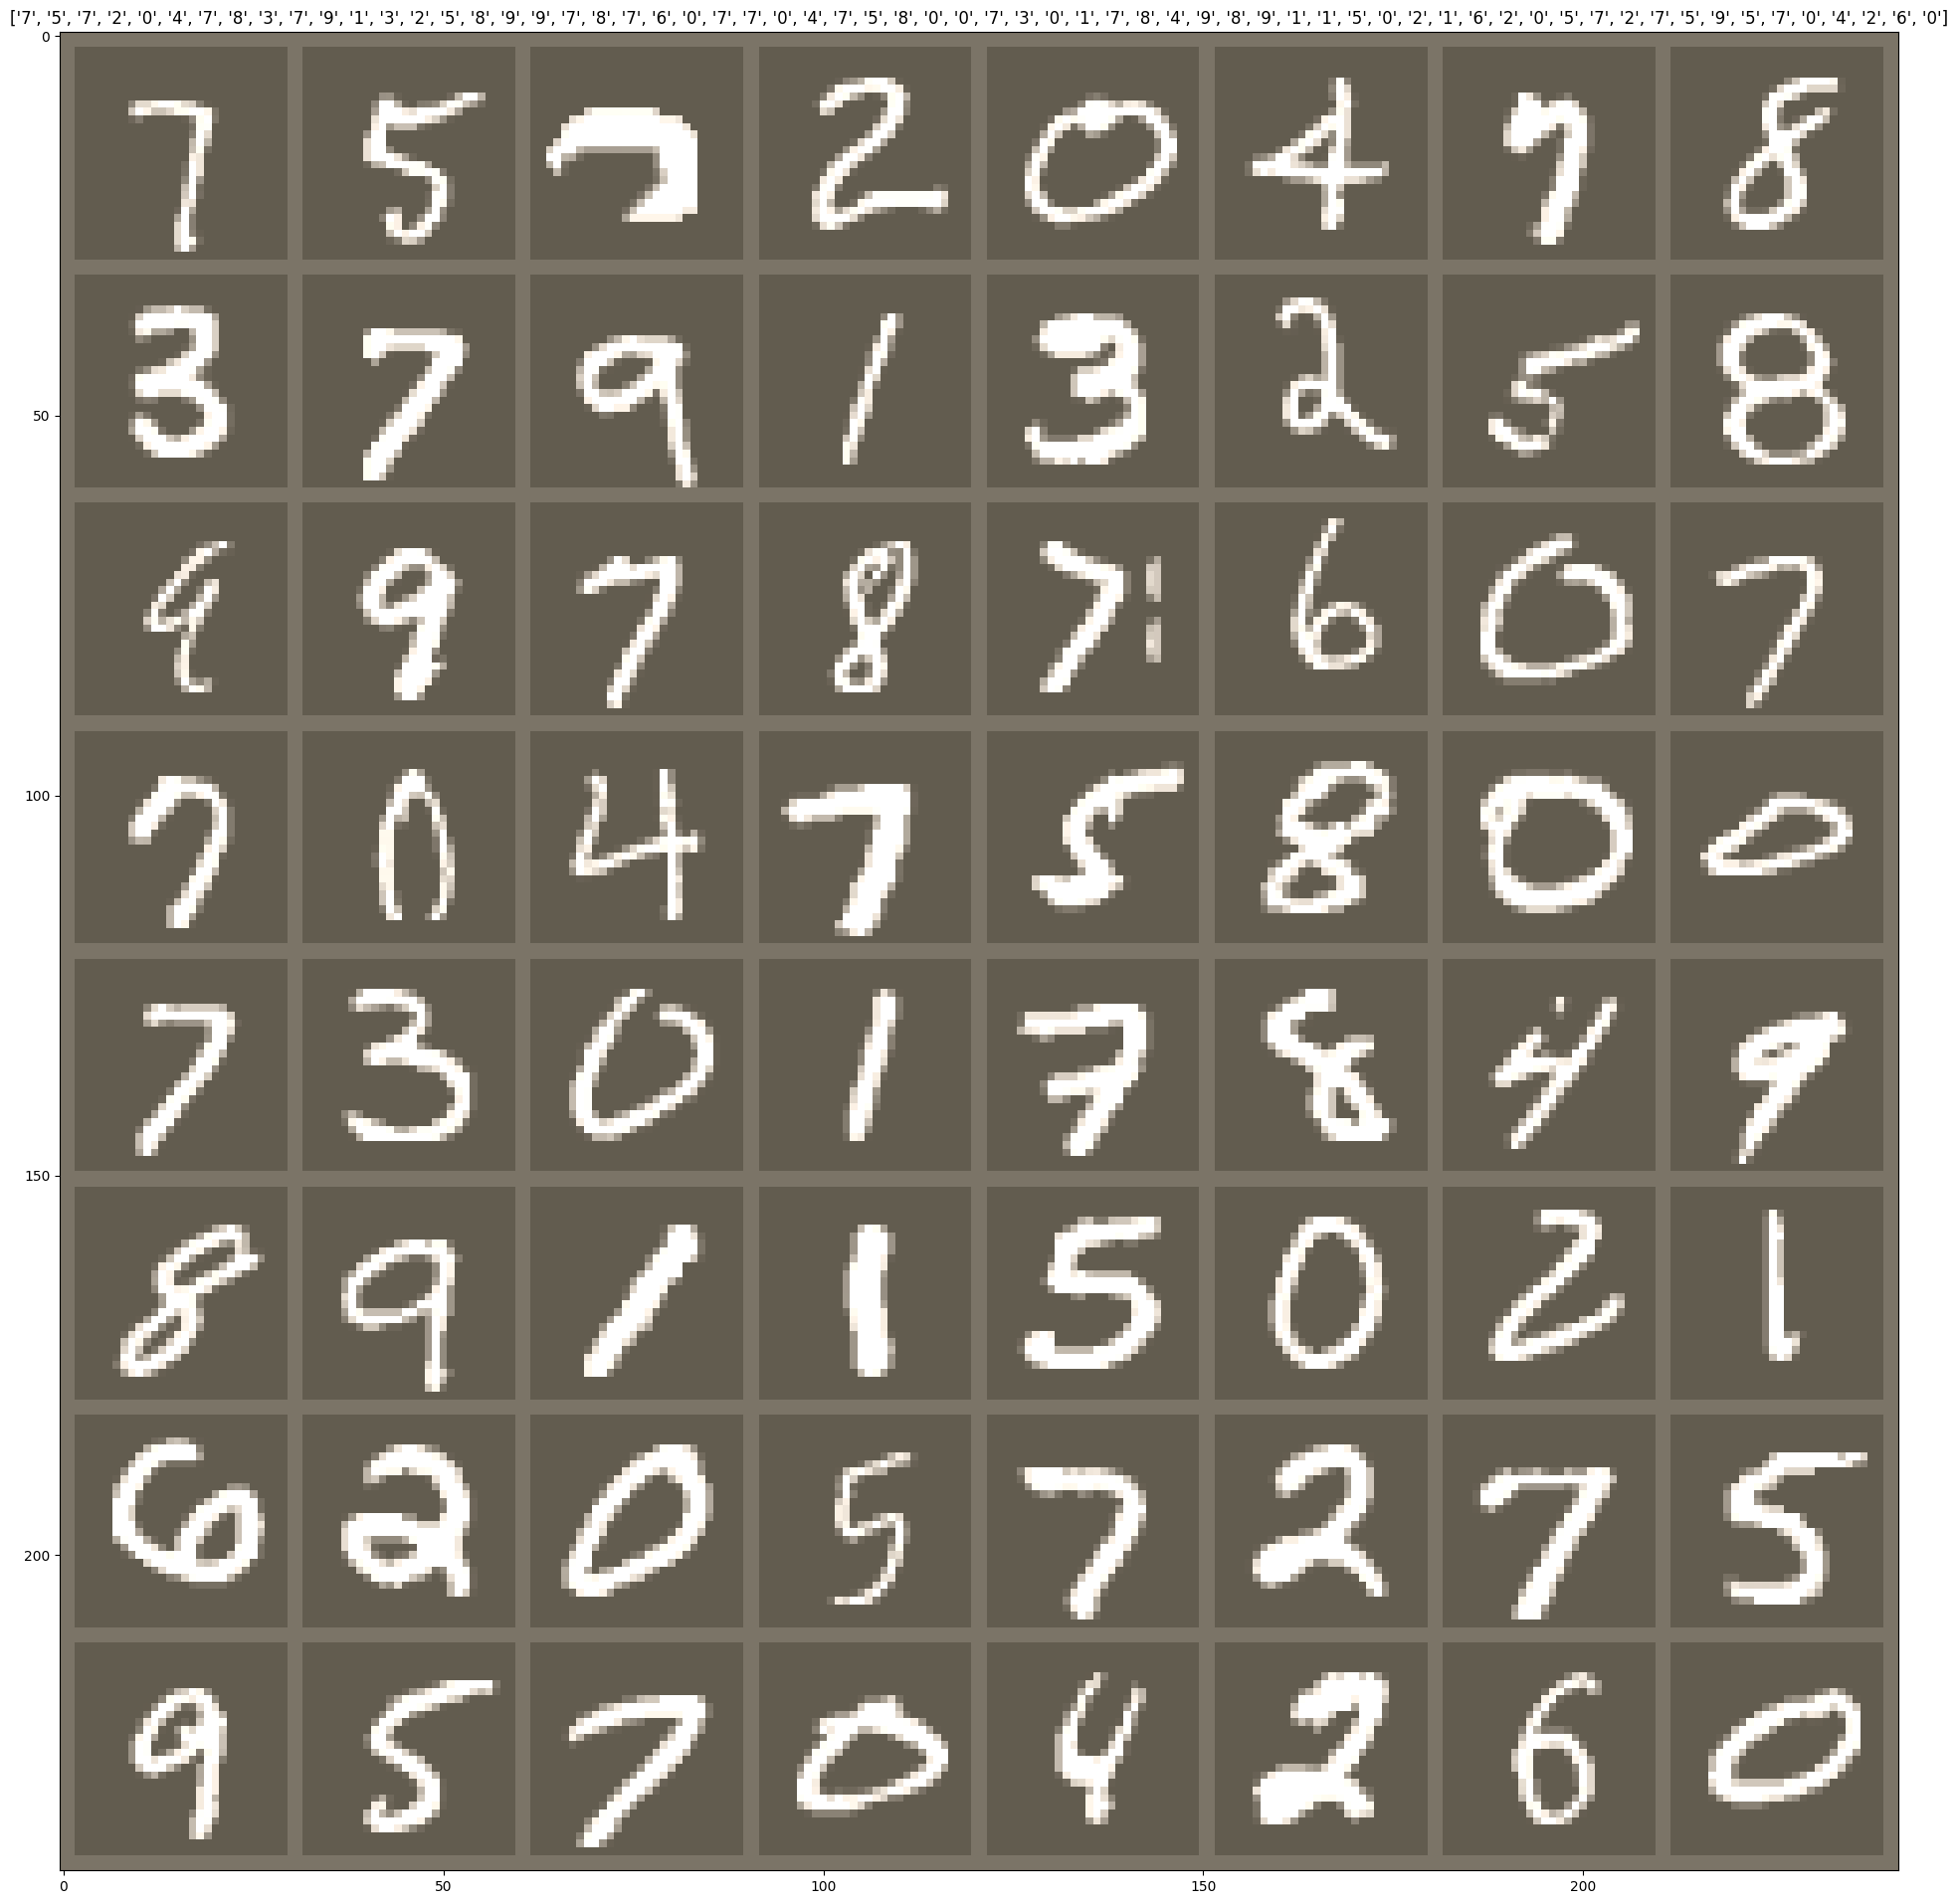

In [8]:
# take a look at data augmentation

def imshow_tensor(image, title=None):
    """Imshow for Tensor."""

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    # You may use np.clip() to clip the value between 0 to 1.

    image = np.clip(image, 0, 1)
    plt.figure(figsize=(24, 24))

    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow_tensor(out, title = [data['train'].classes[x] for x in classes])

Here, we may define our model with the mobilenet v3 small. The output channels might match the original dataset. Therefore, we need to change the last block of network specially for our dataset.

In [9]:
# Define the network with pretrained models.resnet50


model = models.mobilenet_v3_small(pretained = False)

model.classifier = nn.Sequential(

                      #For small
                      nn.Linear(in_features=576, out_features=1024, bias=True),
                      nn.Hardswish(),
                      nn.Dropout(p=0.2, inplace=True),
                      nn.Linear(in_features=1024, out_features=n_classes, bias=True)

                      )

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,528,106 total parameters.
1,528,106 training parameters.


Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve your learning speed in your parameter update by using GPU rather than CPU.

In [10]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

if train_on_gpu:
    model = model.to('cuda')

Train on gpu: True
1 gpus detected.
True False


In [11]:
if train_on_gpu:
    model = model.to('cuda')

Now we can set up the hyper parameters for our network.

In [12]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())


# Set up your criterion and optimizer
# You can use nn.CrossEntropyLoss() as your critenrion
# You can use optim.Adam() as your optimizer with reasonable momentum


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

[(0, '0'),
 (1, '1'),
 (2, '2'),
 (3, '3'),
 (4, '4'),
 (5, '5'),
 (6, '6'),
 (7, '7'),
 (8, '8'),
 (9, '9')]

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([8, 16, 1, 1])
torch.Size([8])
torch.Size([16, 8, 1, 1])
torch.Size([16])
torch.Size([16, 16, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([72, 16, 1, 1])
torch.Size([72])
torch.Size([72])
torch.Size([72, 1, 3, 3])
torch.Size([72])
torch.Size([72])
torch.Size([24, 72, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([88, 24, 1, 1])
torch.Size([88])
torch.Size([88])
torch.Size([88, 1, 3, 3])
torch.Size([88])
torch.Size([88])
torch.Size([24, 88, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([96, 24, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([96, 1, 5, 5])
torch.Size([96])
torch.Size([96])
torch.Size([24, 96, 1, 1])
torch.Size([24])
torch.Size([96, 24, 1, 1])
torch.Size([96])
torch.Size([40, 96, 1, 1])
torch.Size([40])
torch.Size([40])
torch.Size([240, 40, 1, 1])
torch.Size([240])
torch.Size([240])
torch.Size([240, 1, 5, 5])
torch.Siz

Well down! Now we can start our training process here.

In [13]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): model to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch

        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0


        # Set to training

        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu

            if train_on_gpu:
                model = model.cuda()
                data, target = data.cuda(), target.cuda()
            # Clear gradients
            optimizer.zero_grad()

            # Get your output from your model

            model = model.float()
            output = model(data.float())

            # Loss and backpropagation of gradients

            loss = criterion(output, target.long())
            loss.backward()

            # Update the parameters

            optimizer.step()


            # Track train loss by multiplying average loss by number of examples in batch

            train_loss += loss.item() * data.size(0)



            # Calculate accuracy by finding max log probability

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))


            # Need to convert correct tensor from int to float to average

            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))


            # Multiply average accuracy times the number of examples in batch

            train_acc += accuracy.item() * data.size(0)


            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode

                model.eval()


                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu

                    if train_on_gpu:
                        model = model.cuda()
                        data, target = data.cuda(), target.cuda()


                    # Forward pass

                    model = model.float()
                    output = model(data.float())


                    # Validation loss

                    loss = criterion(output, target.long())



                    # Multiply average loss times the number of examples in batch

                    valid_loss += loss.item() * data.size(0)


                    # Calculate validation accuracy

                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))


                    # Multiply average accuracy times the number of examples

                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)


                # Calculate average accuracy

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)


                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict

                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [14]:
from timeit import default_timer as timer
save_file_name = f'mobilenet_v3_model_best_model.pt'
train_on_gpu = cuda.is_available()

model, history = train(model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=10,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 98.14 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.3467 	Validation Loss: 0.1065
		Training Accuracy: 89.19%	 Validation Accuracy: 96.78%
Epoch: 1	100.00% complete. 86.98 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.1205 	Validation Loss: 0.0803
		Training Accuracy: 96.48%	 Validation Accuracy: 97.66%
Epoch: 2	100.00% complete. 85.74 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.0900 	Validation Loss: 0.0613
		Training Accuracy: 97.39%	 Validation Accuracy: 98.26%
Epoch: 3	100.00% complete. 82.63 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0767 	Validation Loss: 0.0675
		Training Accuracy: 97.80%	 Validation Accuracy: 97.95%
Epoch: 4	100.00% complete. 82.32 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.0631 	Validation Loss: 0.0859
		Training Accuracy: 98.16%	 Validation Accuracy: 97.42%
Epoch: 5	100.00% complete. 82.23 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0608 	Validation

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

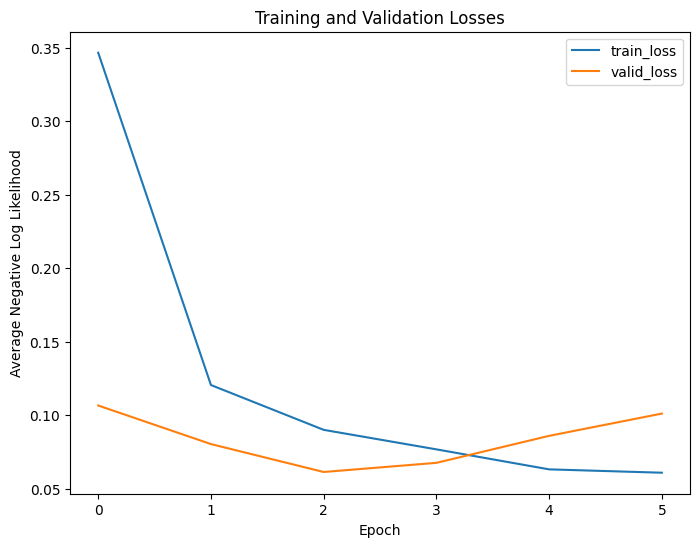

In [15]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

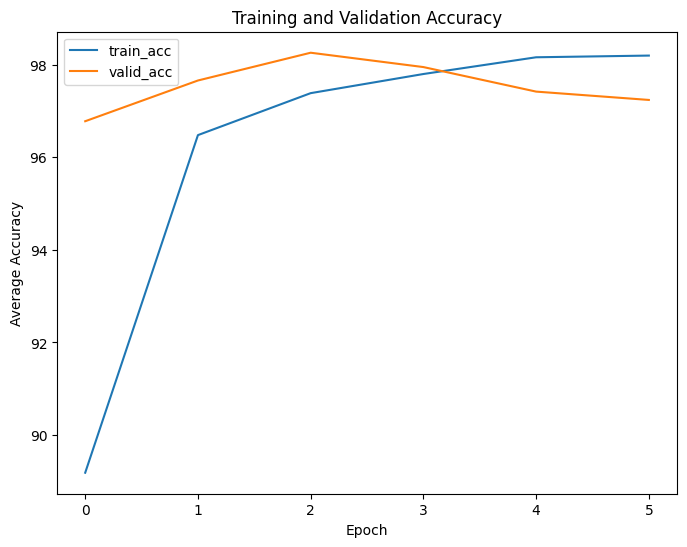

In [16]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


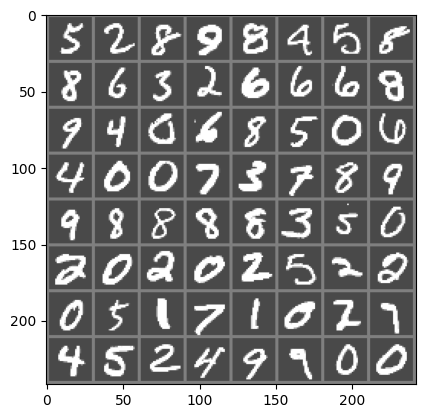

GroundTruth:      5     2     8     9     8     4     5     8     8     6     3     2     6     6     6     8     9     4     0     6     8     5     0     6     4     0     0     7     3     7     8     9     9     8     8     8     8     3     5     0     2     0     2     0     2     5     2     2     0     5     1     7     1     0     2     7     4     5     2     4     9     9     0     0
Prediction:      5     2     8     9     8     4     5     8     8     6     3     2     6     6     6     8     9     4     0     6     8     5     0     6     4     0     0     7     3     7     8     9     9     8     8     8     8     3     5     0     2     0     2     0     2     5     2     2     0     5     1     7     1     0     2     7     4     5     2     4     9     9     0     0


In [17]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = npimg.transpose(1,2,0)

    plt.imshow(npimg)
    plt.show()


dataiter = iter(validationiter)
# get some random training images
# you may use .next() to get the next iteration of validation dataloader

images, labels = dataiter.__next__()

# Get the prediction of images by using your model.

outputs = model(images.cuda().float())
_, predicted = torch.max(outputs, 1)
#predicted


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % categories[labels[j].long()] for j in range(batch_size)))
print('Prediction: ', ' '.join('%5s' % categories[predicted[j].long()] for j in range(batch_size)))